# Historical Quasar Observations
***
## Learning Goals
By the end of this tutorial, you will:
* Understand how to query data on a target from the MAST archive.
* Be able to plot a historic observation coverage plot of a target.
* Learn to plot a spectrum from Hubble

## Introduction
Quasars are extremely luminous astronomical objects that can be found at the center of some galaxies. They are powered by gas spiraling at high velocity into a super-massive black hole. The brightest quasars are capable of outshining all the stars in their galaxy; they can be seen from billions of light-years away. The first quasar ever discovered is called **3c273**. It is one of the most luminous quasars and therefore one of the most luminous objects in the observable universe. It is at a distance of 749 Megaparsecs [1 Megaparsec = 1 million parsecs = 3.26 million lightyears] with an absolute magnitude of −26.7, meaning that if it were at a distance of 10 parsecs, it would be as bright in our sky as the Sun. 

Quasar **3c273** is the our target in this tutorial. We will first search the MAST Archive for all the observations of this quasar. Then, we will display those observations in a historic coverage plot; that is, a plot of the wavelengths in which **3c273** was observed for a given year. This will help us understand what the history of observations of this quasar looks over time. Finally, we will plot a spectrum from one of the observations. 

### Workflow

* [Imports](#Imports)
* [Historic Observation Coverage](#Historical-Observation-Coverage)
    * [Query the MAST Archive](#Query-the-MAST-Archive-by-Object-Name)
    * [Create Plotting Variables](#Create-Plotting-Variables)
        * [Time Data](#Time-Data)
        * [Wavelength Data](#Wavelength-Data)
        * [Mission Names](#Mission-Names)
    * [Plotting Historical Observation Coverage](#Plotting-Historical-Observation-Coverage)
* [Plot a Spectrum](#Plot-a-Spectrum)
    * [Query HST for Spectra](#Query-HST-for-Spectra)
    * [List Available Instrument and Filter Combinations](#List-Available-Instrument-and-Filter-Combinations)
    * [Select Desired Observations](#Select-Observations-with-a-Specific-Instrument-and-Filter-Combination)
    * [Filter for Relevant Products](#Filtering-for-Relevant-Products)
    * [Download the Data](#Download-the-Data-to-Plot)
    * [Plot the Spectrum](#Plot-the-Spectrum)
* [Exercises](#Exercises)

## Imports
The following cell holds the imported packages. These packages are necessary for running the rest of the cells in this notebook. A description of each import is as follows:

* `numpy` to handle array functions
* `pandas` to handle date conversions
* `fits` from astropy.io for accessing FITS files
* `Table` from astropy.table for creating tidy tables of the data
* `matplotlib.pyplot` for plotting data
* `Mast` and `Observations` from astroquery.mast for querying data and observations from the MAST archive

In [1]:
from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Observations

import itertools
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# Historical Observation Coverage
The MAST Archive has data from as early as the 1970s. In this section, we'll search for a target by name and examine its observational history. We'll create a plot of this history, showing when the target was observed, in what wavelength, and by which mission.

## Query the MAST Archive by Object Name

We are going to use the **astroquery.mast** `Observations` package to gather our data from the MAST Archive. In this tutorial, we will use the `Observations.query_object()` function which takes the name of the target and an optional radius. If you don't specify a radius, 0.2 degrees will be used by default. For more information about queries you can read the [astroquery.mast readthedocs](https://astroquery.readthedocs.io/en/latest/mast/mast.html).

In [2]:
# Define target name
target_name = "3c273"

# We'll name the data "obs_table" for "observations table"
obs_table = Observations.query_object(target_name)

# Print out the first 10 entries with limited columns, if you want to see a preview
columns = ['intentType', 'obs_collection', 'wavelength_region', 'target_name', 'dataproduct_type', 'em_min']
obs_table[:10][columns]

intentType,obs_collection,wavelength_region,target_name,dataproduct_type,em_min
str11,str11,str19,str29,str10,float64
science,WUPPE,UV,3C273,spectrum,155400000000.0
science,WUPPE,UV,3C273,spectrum,153400000000.0
science,TESS,Optical,TESS FFI,image,600.0
science,TESS,Optical,377297839,timeseries,600.0
science,TESS,Optical,377297839,timeseries,600.0
science,SWIFT,UV,3C273,cube,167900000000.0
science,SWIFT,OPTICAL,3C273,cube,493000000000.0
science,SWIFT,UV;OPTICAL,3C273,cube,160900000000.0
science,SWIFT,UV;OPTICAL,3C273,cube,159300000000.0


It looks like we have excellent observation coverage for this target. To best understand these results, we'll make a plot below.

## Create Plotting Variables
Before we start parsing our observations table, let's recall what we want to do with it.

First, we want to plot a historical observation coverage plot, where the horizontal axis will be time and the vertical axis will be observed wavelength. We should label or color each observation according to what mission it corresponds to. So, we are going need variables for:
* array of times of all observations = `times`
* array of wavelengths of all observations = `waves`
* array of mission names of all observations = `mission` <br> 

We will want to modify the queried data for easy visualization:
1) We will want to convert the Modified Julian Date (MJD) to a calendar year so when we plot the timeline, it will be easy to tell when each observation was made. 
2) MAST archives the minimum and maximum wavelength of the observation; however, we only want one wavelength per observation for our plot. We will calculate the average of the min/max values, and use this number instead.

### Time Data
We'll use `t_min` for our time data, which corresponds to the beginning of the observation. This is "close enough" for our plot, since it will span multiple decades.

In [3]:
# Parse the observations table to get the Time data
obs_times = obs_table["t_min"]

# Convert MJD to Calendar Date:
# Initialize list for times as calendar dates
times = []
# Loop through times queried from MAST
for t in obs_times:
    # Convert MJD to Julian date
    t = t + 2400000.5
    # Convert Julian date to Calendar date 
    time = pd.to_datetime(t, unit='D', origin='julian')
    # Add converted date to times list
    times.append(time.to_numpy())

# Change list to numpy array for easy plotting
times = np.array(times)

### Wavelength Data

As explained above, we'll compute the average value reported for the wavelength. 

One complication here is the presence of a database error in some legacy missions. MAST's current standard is to report wavelengths in nanometers, but some older missions reported the value in meters. Work is ongoing to bring these legacy missions up date; the code in the cell below will correctly parse the values, whether or not the database has been fixed.

In [4]:
# Parse observations table to get the wavelength data
wavelength_min = obs_table["em_min"]
wavelength_max = obs_table["em_max"]

# Get the average wavelength
wavelength_avg = (wavelength_max+wavelength_min)/2

# Some older missions have wavelengths that are off by a factor of 10^9
waves = []
for wave in wavelength_avg:
    if wave/1e9 >= 1:
        waves.append(wave/1e9)
    else:
        waves.append(wave)
        
# change list to numpy array
nm_waves = np.array(waves)

/tmp/ipykernel_2002/4029485612.py:17: UserWarning: Warning: converting a masked element to nan.
  nm_waves = np.array(waves)


It will also be useful for us to convert this value to meters; when we create a log plot, this will provide a much more easily interpretable chart.

In [5]:
meter_waves = nm_waves*10**-9

### Mission Names
We'll use the mission names to create labels for the data. It will make our plot a little noisier, but it's good to know where the data is coming from.

In [6]:
#Parse the observations table to get the mission names data
mission = obs_table["obs_collection"]
mission = np.array(mission)

## Plotting Historical Observation Coverage

We want to visualize the history of observations of **3c273** according to the wavelength of the observation. We'll change the color and shape of each point to indicate which mission made the observation. 

**Note:** Since the wavelength data MAST spans a broad range of values, we'll plot our y-axis logarithmically.

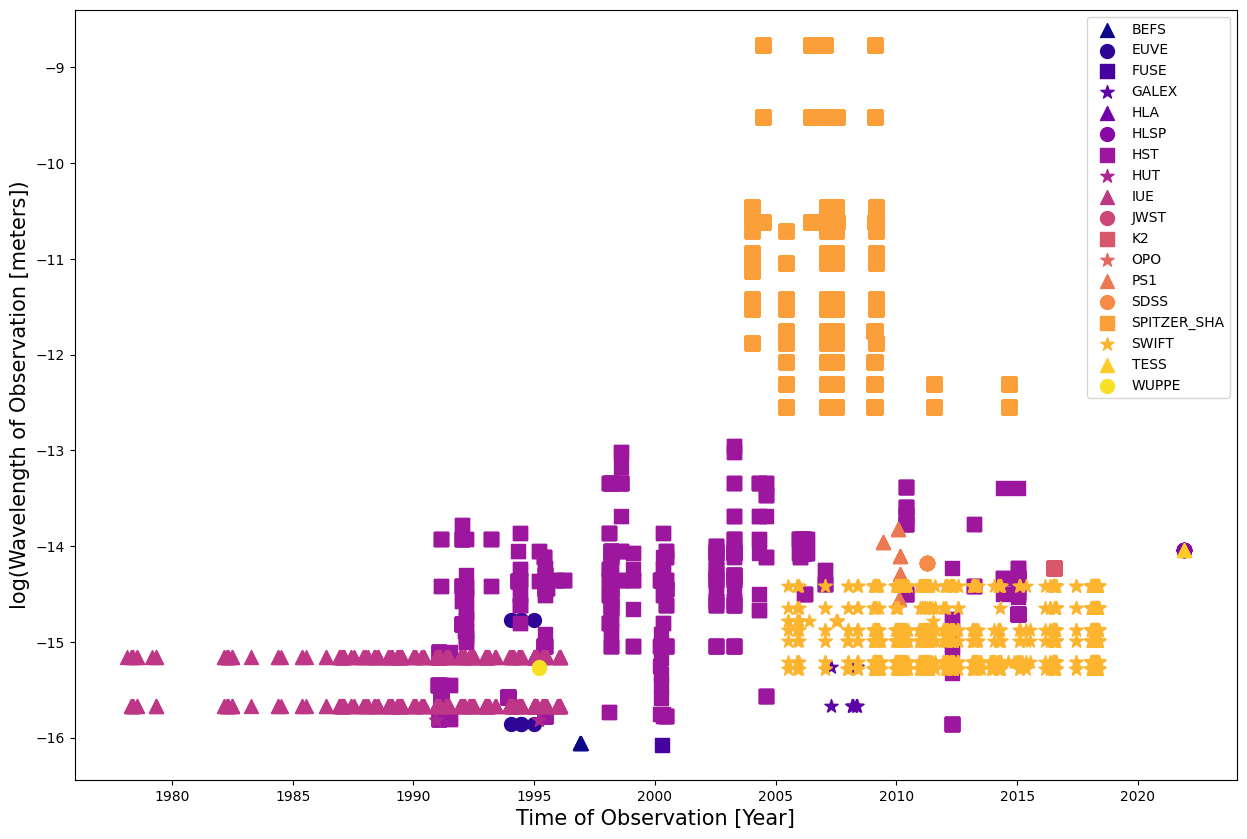

In [7]:
# Initialize the figure
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot()
        
# Set a color for every unique mission name
num_colors = len(np.unique(mission))
cm = mpl.colormaps["plasma"]
ax.set_prop_cycle(color=[cm(1.*i/num_colors) for i in range(num_colors)])
marker = itertools.cycle(('^', 'o', 's', '*')) 

# Loop through the mission names
for i in np.unique(mission):
    # Filter times and wavelengths by mission name
    ind = np.where(mission == i)
    # Plot the mission in its color as a scatterplot
    ax.scatter(times[ind], np.log(meter_waves[ind]), label=i, s=100, marker=next(marker))


# Place the legend
plt.legend()  

# Set the label of the x and y axes
plt.xlabel("Time of Observation [Year]", fontsize=15)
plt.ylabel("log(Wavelength of Observation [meters])", fontsize=15)

# Show the plot
plt.show()

Incredible! There are many observations across the wavelength spectrum, going back to the 1970s.

Since approximately half of this range is taken up by Spitzer, let's create a new plot focused on near-optical data.

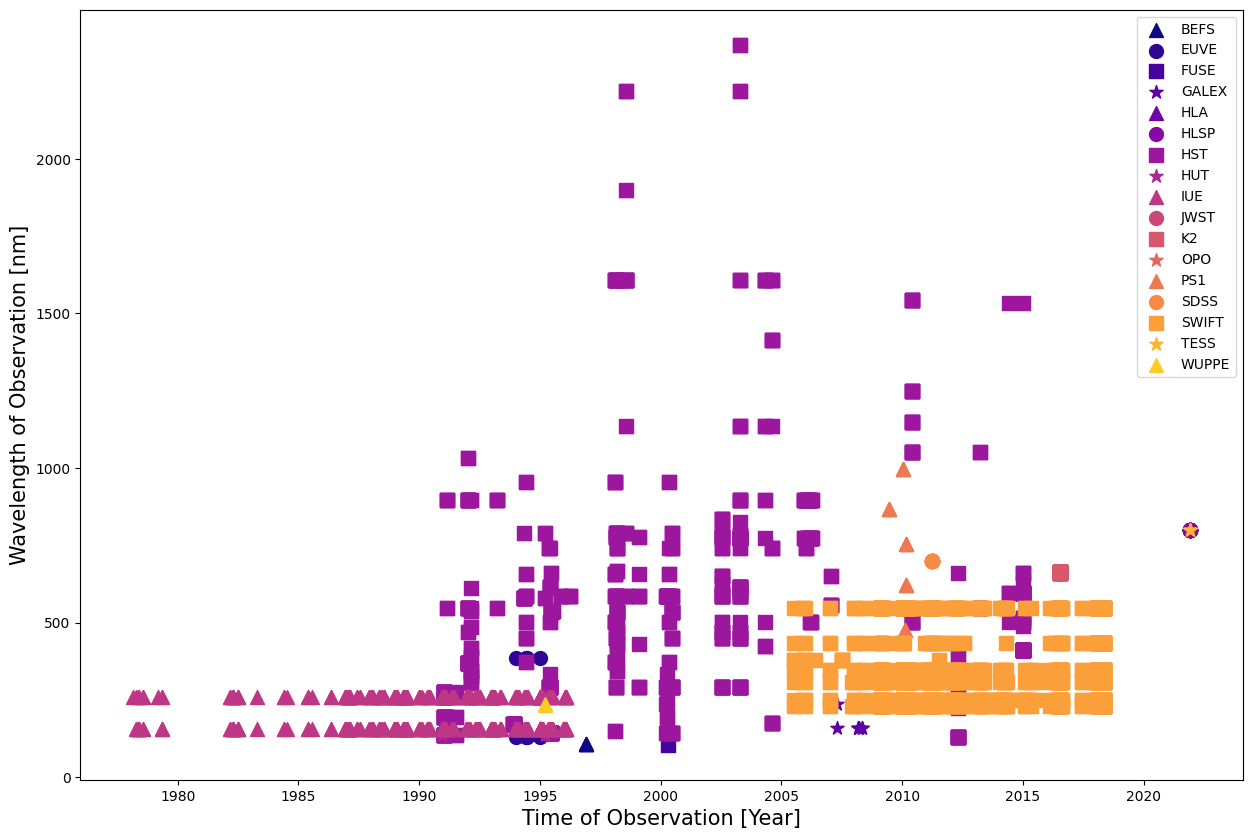

In [8]:
# Initialize the figure
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot()
        
# Set a color for every unique mission name
cm = mpl.colormaps["plasma"]
num_colors = len(np.unique(mission))
ax.set_prop_cycle(color=[cm(1.*i/num_colors) for i in range(num_colors)])
marker = itertools.cycle(('^', 'o', 's', '*')) 

# Loop through the mission names
for i in np.unique(mission):
    # Filter times and wavelengths by mission name
    ind = np.where(mission == i)
    # Plot the mission in its color as a scatterplot
    if i != "SPITZER_SHA":
        ax.scatter(times[ind], nm_waves[ind], label=i, s=100, marker=next(marker))


# Place the legend
plt.legend()  

# Set the label of the x and y axes
plt.xlabel("Time of Observation [Year]", fontsize=15)
plt.ylabel("Wavelength of Observation [nm]", fontsize=15)

# Show the plot
plt.show()

This gives us a much better view of the wavelength coverage near the optical regime. We have good coverage here, thanks to Hubble. Let's take a look at some of this data and create a spectrum.

# Plot a Spectrum

Now, we want to plot a spectrum from one of our observations, where the x-axis will be wavelength and the y-axis will be flux (brightness).

We can use our historical observational coverage plot to choose which observation to plot. Let's pick one from the Hubble Space Telescope (HST). Its high resolution coverage of the ultraviolet makes emission and absorption lines in this region clear; this can help us deduce the composition of **3c273**.

### Query HST for Spectra

In [9]:
# Query all the observations of 3c273 from the Hubble Space Telescope
hst_table = Observations.query_criteria(objectname="3c273",
                                        radius="10 arcsec",
                                        dataproduct_type="spectrum",
                                        obs_collection="HST")

# Let's print out some relevant columns of this table
columns = ["instrument_name", "filters", "target_name", "obs_id", "calib_level", "t_exptime"]
hst_table[columns][:10]

instrument_name,filters,target_name,obs_id,calib_level,t_exptime
str13,str11,str10,str29,int64,float64
FOS/BL,MIRROR,TALED,y0g40104t,1,53.76
FOS/BL,MIRROR,PG1226+023,y0g40105t,1,120.32
FOS/RD,G270H,WAVE,y0g4020kt,2,2.0
FOS/RD,G190H,WAVE,y0g40208t,2,8.0
FOS/BL,MIRROR,PG1226+023,y0g40103t,1,43.2
FOS/BL,MIRROR,PG1226+023,y0g40102t,1,0.24
FOS/RD,MIRROR,PG1226+023,y0g40201t,1,1.2
FOS/BL,MIRROR,3C273,y0nb0101t,1,0.5
FOS/RD,G270H,WAVE,y0g4020gt,2,10.0


### List Available Instrument and Filter Combinations

Most telescopes have multiple instruments and observing modes. Here we'll print a summary of the filters and instruments that are available for our search results. This is useful to us because the different instruments aboard Hubble will cover different wavelength ranges.

In our table, we'll also create two new columns: average exposure time and maximum exposure time. This can help constrain searches for faint objects, or targets that need a longer exposure to be fully resolved.

In [10]:
hst_table['count'] = 1
columns = hst_table.group_by(["instrument_name", "filters"])
summary_table = columns["instrument_name", "filters", "count"].groups.aggregate(np.sum)

# Create two new columns: the average exposure time, and the maximum
summary_table["avg_exptime"] = columns['t_exptime'].groups.aggregate(np.mean)
summary_table["max_exptime"] = columns['t_exptime'].groups.aggregate(np.max)
summary_table["avg_exptime"].format = ".1f"
summary_table["max_exptime"].format = ".1f"

#Take a look at the summary table
summary_table

instrument_name,filters,count,avg_exptime,max_exptime
str13,str11,int64,float64,float64
COS,G130M,1,4002.3,4002.3
COS/FUV,G130M,8,564.4,1192.2
FOS/BL,G130H,13,822.8,2000.0
FOS/BL,G190H,2,1440.0,1440.0
FOS/BL,G270H,1,1440.0,1440.0
FOS/BL,MIRROR,6,36.7,120.3
FOS/RD,G190H,9,607.4,1410.0
FOS/RD,G270H,11,494.1,1410.0
FOS/RD,MIRROR,5,39.5,120.3


### Select Observations with a Specific Instrument and Filter Combination

We are interested in an ultraviolet observation that has an appropriate number of observations. Many of these instrument and filter combinations only have 1 or 2 observations. The COS G130M data looks like a good possibility. Let's look at the observations for that mode. 

In [11]:
g130m_table = hst_table['obsid', 'obs_id', 'target_name', 'calib_level',
                        't_exptime', 'filters', 'em_min', 'em_max'][hst_table['filters'] == 'G130M']

# Print out the table of data for this specific filter configuration
g130m_table

obsid,obs_id,target_name,calib_level,t_exptime,filters,em_min,em_max
str9,str29,str10,int64,float64,str11,float64,float64
24140742,lbgl31rhq,3C273,1,2.0,G130M,115.0,145.0
24140740,lbgl31rfq,3C273,1,398.0,G130M,115.0,145.0
24842821,lbgl31040,3C273,3,555.04,G130M,115.0,145.0
24842818,lbgl31010,3C273,3,555.008,G130M,115.0,145.0
24140741,lbgl31rgq,3C273,1,113.0,G130M,115.0,145.0
24842819,lbgl31020,3C273,3,1192.192,G130M,115.0,145.0
199016099,hst_hasp_12038_cos_3c273_lbgl,3C273,2,4002.2720000000004,G130M,113.54127,146.97034
24842822,lbgl31050,3C273,3,590.016,G130M,115.0,145.0
24842820,lbgl31030,3C273,3,1110.016,G130M,115.0,145.0


To make the next steps reproducable, we'll select just one observation from above.

In [12]:
# Fixing for reproducibility
sel_table = g130m_table[g130m_table['obs_id'] == 'lbgl31020']

#Take a look at the selected observation's data table
sel_table

obsid,obs_id,target_name,calib_level,t_exptime,filters,em_min,em_max
str9,str29,str10,int64,float64,str11,float64,float64
24842819,lbgl31020,3C273,3,1192.192,G130M,115.0,145.0


### Filtering for Relevant Products
Our table of selected observations includes not just the spectra but also RAW files, dark scans, bias scans, and others, all of which are used in the calibration of the data. These are not necessary for plotting the spectrum, so we'll filter them out by selecting only the Minimum Recommended Products which are marked as intended for science.

In [13]:
# Query the observations from MAST to get a list of products for our selected observation
data_products = Observations.get_product_list(sel_table)

# Get the minimum required products
filtered = Observations.filter_products(data_products, productType='SCIENCE', 
                                        productGroupDescription='Minimum Recommended Products')

# Let's take a look at the products available for our selected observation
filtered

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str3,str8,str29,str62,str1,str65,str9,str28,str12,str1,str6,str8,str5,str43,int64,str8,str6,int64,str5
24842819,HST,spectrum,lbgl31020,DADS XSM file - Calibrated combined extracted 1D spectrum COS,D,mast:HST/product/lbgl31020_x1dsum.fits,SCIENCE,Minimum Recommended Products,X1DSUM,--,CALCOS,3.6.0rc1,12038,lbgl31020_x1dsum.fits,1814400,24842819,PUBLIC,3,G130M


### Download the Data to Plot

In [14]:
# Download the data for our selected observation
data = Observations.download_products(filtered)

 [Done]


We've downloaded a [Flexible Image Transport System](https://fits.gsfc.nasa.gov/) (FITS) file. This is a very common file type used in astronomy for holding data of multiple dimensions. FITS files can hold images but can also contain spectral and temporal information. 

We can read the columns of our FITS file to see that it holds two segements of data for this observation, FUVA and FUVB. These are two different subsections of the far-ultraviolet spectrum that Hubble observes.

To plot a spectrum, we'll need to get the data from the `Wavelength` and `Flux` columns. 

In [15]:
#Take a peek at the FITS file we downloaded
filename = data['Local Path'][0]
fits.info(filename)

#Read the table with the spectrum from the FITS file
tab = Table.read(filename)
tab

Filename: ./mastDownload/HST/lbgl31020/lbgl31020_x1dsum.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     182   ()      
  1  SCI           1 BinTableHDU    319   2R x 16C   [4A, 1D, 1J, 16384D, 16384E, 16384E, 16384E, 16384E, 16384E, 16384E, 16384E, 16384E, 16384E, 16384E, 16384I, 16384E]   


SEGMENT,EXPTIME,NELEM,WAVELENGTH,FLUX,ERROR,ERROR_LOWER,GROSS,GCOUNTS,VARIANCE_FLAT,VARIANCE_COUNTS,VARIANCE_BKG,NET,BACKGROUND,DQ,DQ_WGT
,s,,Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),erg / (Angstrom s cm2),ct / s,ct,ct,ct,ct,ct / s,ct / s,,
bytes4,float64,int32,float64[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],int16[16384],float32[16384]
FUVA,1192.192,16384,1287.7223257326257 .. 1451.0011721766848,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0
FUVB,1192.192,16384,1134.4437679463244 .. 1297.6947517877506,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0


### Plot the Spectrum

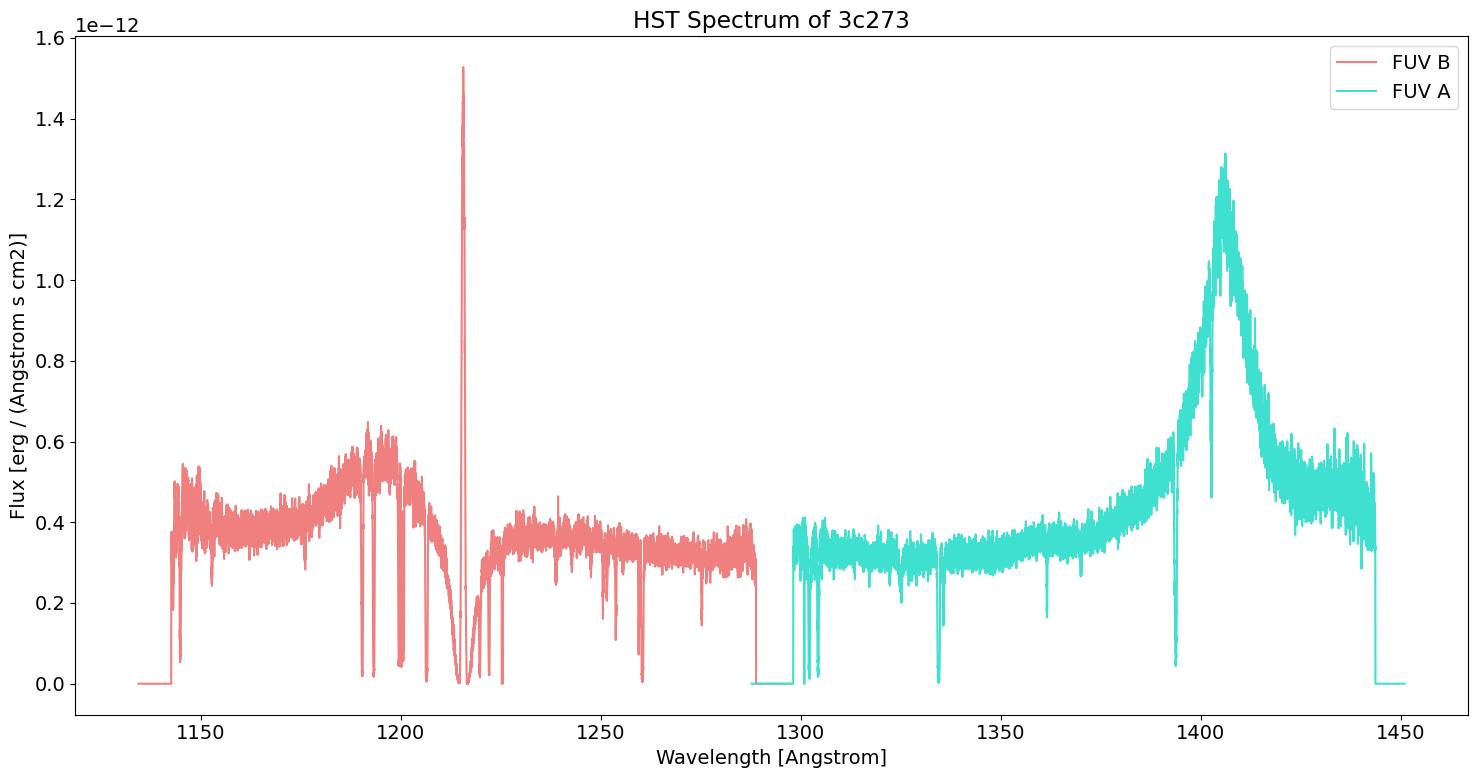

In [16]:
# Make the figure and set the font size globally
plt.rcParams.update({"font.size": 14})
plt.figure(1, (15, 8))

# Gather the arrays from our data table
waves = tab['WAVELENGTH']
fluxes = tab["FLUX"]
segment = tab['SEGMENT']

# You'll notice from our data table that there are two segments to this observation, FUV A and FUV B
# Let's parse the spectra by their segment and plot them separately
ind_A = np.squeeze(np.where(fluxes != 0) and np.where(segment == 'FUVA'))
waves_A = waves[ind_A]
fluxes_A = fluxes[ind_A]
ind_B = np.squeeze(np.where(fluxes != 0) and np.where(segment == 'FUVB'))
waves_B = waves[ind_B]
fluxes_B = fluxes[ind_B]

# Plot both segments
plt.plot(waves_B, fluxes_B, label="FUV B", color='lightcoral')
plt.plot(waves_A, fluxes_A, label="FUV A", color='turquoise')

# Set the x and y axes labels and the title
plt.xlabel('Wavelength [{}]'.format(tab['WAVELENGTH'].unit))
plt.ylabel('Flux [{}]'.format(tab['FLUX'].unit))
plt.title("HST Spectrum of 3c273")

# Plot the legend
plt.legend()

# Give the figure a tight layout (optional)
plt.tight_layout()

# Exercises
## Recognizing Familiar Emission Lines
Look at the spectrum we plotted, does anything stand out to you? 

In astronomy, spectral features at specific wavelengths are indicative of known elements. For example, an emission line at 1216 Angstroms is called Lyman Alpha. It is produced when an orbital electron of a hydrogen atom drops from the first excited state down to the ground state, emitting a photon. 

Does **3c273** have a Lyman Alpha emission line? Plot a vertical line at 1216 Angstroms to find out.

## Solution
This question is a bit disingenuous. We can add plot a vertical line at the Lyman Alpha wavelength, and we'll actually find quite a nice fit for our data.

In [17]:
# appending these lines to the last cell above will give us the answer
# xval = 1216 #Lyman Alpha in Angstroms
# plt.axvline(xval, color = "black", linestyle = "--")

**However**, our target is an extragalactic quasar, so we should expect some redshifting. Indeed, the peak we've found here isn't from the quasar at all! It's contamination from a source along our line-of-sight.

The "true" Lyman Alpha emission is actually the enormous, broadened peak in FUV A. As an advanced exercise for the reader, you might try fitting a normal distribution to that peak, determining the center of the wavelength, then calculating the redshift using $$z = \frac{\lambda_{obs}-\lambda_{actual}}{\lambda_{actual}}$$

# Citations

* [Citation for `astropy`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)


# About this Notebook

**Author**: Emma Lieb <br>
**Last updated:** Apr 2023

If you have questions, comments, or other feedback, please contact the Archive HelpDesk at archive@stsci.edu.

***
 <img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

[Return to top of page](#Historical-Quasar-Observations)